In [1]:
import pandas as pd
import numpy as np
import argparse
import glob
import os
import pyranges as pr
from gtfparse import read_gtf #initially tested with version 1.3.0 
from tqdm import tqdm
import gzip
import torch
import time 
import seaborn as sns 

In [2]:
def process_gtf(gtf_file): 

    #[1] extract all exons from gtf file provided 
    gtf = read_gtf(gtf_file) #to reduce the speed of this, can just get rows with exon in the feature column (preprocess this before running package)? check if really necessary
    gtf_exons = gtf[(gtf["feature"] == "exon")]
    #remove "chr" from chromosome names only if present
    if gtf_exons['seqname'].str.contains('chr').any():
        gtf_exons['seqname'] = gtf_exons['seqname'].map(lambda x: x.lstrip('chr').rstrip('chr'))
    #make pyranges object
    gtf_exons_gr = pr.from_dict({"Chromosome": gtf_exons["seqname"], "Start": gtf_exons["start"], "End": gtf_exons["end"], "Strand": gtf_exons["strand"], "gene_id": gtf_exons["gene_id"], "gene_name": gtf_exons["gene_name"], "transcript_name": gtf_exons["transcript_name"], "transcript_id": gtf_exons["transcript_id"], "exon_number": gtf_exons["exon_number"], "transcript_biotype": gtf_exons["transcript_biotype"]})
    #remove those exons where exon start == exon end 
    gtf_exons_gr = gtf_exons_gr[ ~ (gtf_exons_gr.Start == gtf_exons_gr.End)]
    #remove genes with no gene names (most likely novel genes?/not fully annotated)
    gtf_exons_gr = gtf_exons_gr[ ~ (gtf_exons_gr.gene_name == "")]
    # When do I need to do this? depends on gtf file used? base 0 or 1?
    gtf_exons_gr.Start = gtf_exons_gr.Start-1
    gtf_exons_gr.End = gtf_exons_gr.End.astype("int64")
    # Drop duplicated positions on same strand 
    gtf_exons_gr = gtf_exons_gr.drop_duplicate_positions(strand=True) #why are so many gone after this? 
    return(gtf_exons_gr)

In [3]:
def process_gtf_trans(gtf_file): 

    #[1] extract all exons from gtf file provided 
    gtf = read_gtf(gtf_file) #to reduce the speed of this, can just get rows with exon in the feature column (preprocess this before running package)? check if really necessary
    gtf_exons = gtf[(gtf["feature"] == "transcript")]
    #remove "chr" from chromosome names only if present
    if gtf_exons['seqname'].str.contains('chr').any():
        gtf_exons['seqname'] = gtf_exons['seqname'].map(lambda x: x.lstrip('chr').rstrip('chr'))
    #make pyranges object
    gtf_exons_gr = pr.from_dict({"Chromosome": gtf_exons["seqname"], "Start": gtf_exons["start"], "End": gtf_exons["end"], "Strand": gtf_exons["strand"], "gene_id": gtf_exons["gene_id"], "gene_name": gtf_exons["gene_name"], "transcript_name": gtf_exons["transcript_name"], "transcript_id": gtf_exons["transcript_id"], "exon_number": gtf_exons["exon_number"], "transcript_biotype": gtf_exons["transcript_biotype"]})
    #remove those exons where exon start == exon end 
    gtf_exons_gr = gtf_exons_gr[ ~ (gtf_exons_gr.Start == gtf_exons_gr.End)]
    #remove genes with no gene names (most likely novel genes?/not fully annotated)
    gtf_exons_gr = gtf_exons_gr[ ~ (gtf_exons_gr.gene_name == "")]
    # When do I need to do this? depends on gtf file used? base 0 or 1?
    gtf_exons_gr.Start = gtf_exons_gr.Start-1
    gtf_exons_gr.End = gtf_exons_gr.End.astype("int64")
    # Drop duplicated positions on same strand 
    gtf_exons_gr = gtf_exons_gr.drop_duplicate_positions(strand=True) #why are so many gone after this? 
    return(gtf_exons_gr)

In [4]:
gtf_file="/gpfs/commons/groups/knowles_lab/Karin/genome_files/Homo_sapiens.GRCh38.108.chr.gtf"

In [5]:
gtf_gr_trans = process_gtf_trans(gtf_file)
gtf_gr_trans = gtf_gr_trans.df 
coords = gtf_gr_trans[["Chromosome", "Start", "End", "Strand", "transcript_id"]].drop_duplicates()
coords.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level']


Warning! Start and End columns now have different dtypes: int32 and int64


,Chromosome,Start,End,Strand,transcript_id
0,1,1471764,1497848,+,ENST00000673477
1,1,1478025,1497848,+,ENST00000472194
2,1,1479048,1482662,+,ENST00000378736
3,1,1483484,1496202,+,ENST00000485748
4,1,1484568,1496201,+,ENST00000474481


In [6]:
gtf_gr = process_gtf(gtf_file)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level']


Warning! Start and End columns now have different dtypes: int64 and int32


In [7]:
# the transcript coordinates are for pre-mRNA but these could have big introns that we don't want to evaluate coverage over 
# use exons to get total mature RNA isoform lengths and assess their coverage 
gtf_gr.feature_length = gtf_gr.End - gtf_gr.Start

In [8]:
gtf_gr = gtf_gr.df
gtf_gr.head()

,Chromosome,Start,End,Strand,gene_id,gene_name,transcript_name,transcript_id,exon_number,transcript_biotype,feature_length
0,1,1471764,1472089,+,ENSG00000160072,ATAD3B,ATAD3B-206,ENST00000673477,1,protein_coding,325
1,1,1477273,1477350,+,ENSG00000160072,ATAD3B,ATAD3B-206,ENST00000673477,2,protein_coding,77
2,1,1478643,1478745,+,ENSG00000160072,ATAD3B,ATAD3B-206,ENST00000673477,3,protein_coding,102
3,1,1479048,1479108,+,ENSG00000160072,ATAD3B,ATAD3B-206,ENST00000673477,4,protein_coding,60
4,1,1480866,1480936,+,ENSG00000160072,ATAD3B,ATAD3B-206,ENST00000673477,5,protein_coding,70


In [9]:
gtf_gr.transcript_biotype.value_counts()

protein_coding                        313214
lncRNA                                 71004
retained_intron                        70980
protein_coding_CDS_not_defined         59176
nonsense_mediated_decay                56042
processed_pseudogene                    7124
unprocessed_pseudogene                  4990
transcribed_unprocessed_pseudogene      4898
processed_transcript                    2784
misc_RNA                                1970
snRNA                                   1898
miRNA                                   1852
transcribed_unitary_pseudogene           850
snoRNA                                   606
rRNA_pseudogene                          496
transcribed_processed_pseudogene         426
protein_coding_LoF                       372
non_stop_decay                           305
IG_V_gene                                284
IG_V_pseudogene                          282
unitary_pseudogene                       231
TR_V_gene                                213
TEC       

In [10]:
pc = gtf_gr[gtf_gr.transcript_biotype == "protein_coding"]
nc = gtf_gr[gtf_gr.transcript_biotype == "lncRNA"]

In [11]:
# group by transcript_id then sum up feature_lengths to get total trancsript lengths
pc_trans_lengths = pc.groupby(["gene_name", "transcript_id"])["feature_length"].sum() 
nc_trans_lengths = nc.groupby(["gene_name", "transcript_id"])["feature_length"].sum() 

In [12]:
pc_trans_lengths = pd.DataFrame(pc_trans_lengths)
nc_trans_lengths = pd.DataFrame(nc_trans_lengths)

Text(0, 0.5, 'Percentile')

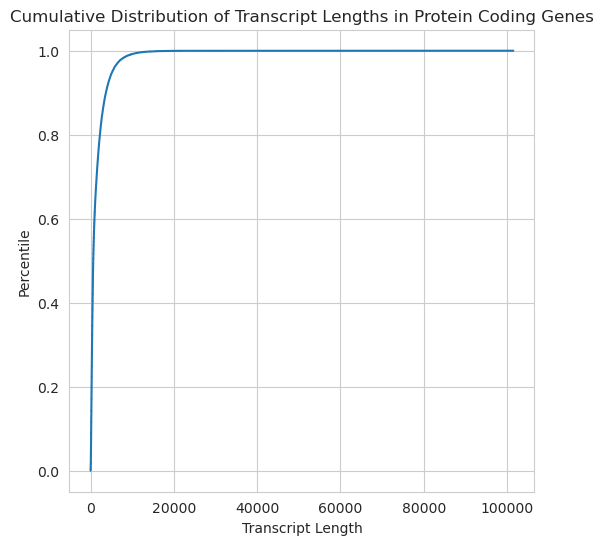

In [13]:
# figure out which percentile each feature_length falls into in pc_trans_lengths
lengths = pc_trans_lengths.sort_values("feature_length")
lengths = lengths.feature_length.values
lengths = pd.Series(lengths)
lengths[len(lengths)] = lengths.iloc[-1]

cum_dist = np.linspace(0.,1.,len(lengths))
ser_cdf = pd.Series(cum_dist, index=lengths)

# define plt 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
ser_cdf.plot(drawstyle='steps', figsize=(6,6), title="Cumulative Distribution of Transcript Lengths in Protein Coding Genes")
plt.xlabel("Transcript Length")
plt.ylabel("Percentile")

Text(0, 0.5, 'Percentile')

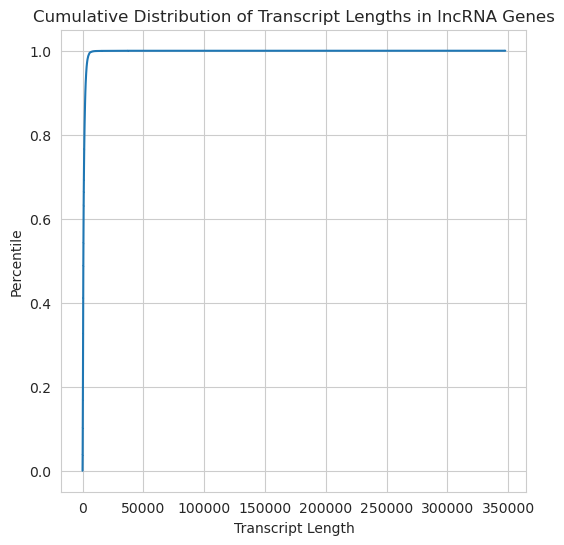

In [14]:
# figure out which percentile each feature_length falls into in pc_trans_lengths
lengths = nc_trans_lengths.sort_values("feature_length")
lengths = lengths.feature_length.values
lengths = pd.Series(lengths)
lengths[len(lengths)] = lengths.iloc[-1]

cum_dist = np.linspace(0.,1.,len(lengths))
ser_cdf = pd.Series(cum_dist, index=lengths)

# define plt 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
ser_cdf.plot(drawstyle='steps', figsize=(6,6), title="Cumulative Distribution of Transcript Lengths in lncRNA Genes")
plt.xlabel("Transcript Length")
plt.ylabel("Percentile")

In [ ]:
# number of exons per transcript 

Text(0.5, 1.0, 'Distribution of Transcript Lengths in Protein Coding Genes')

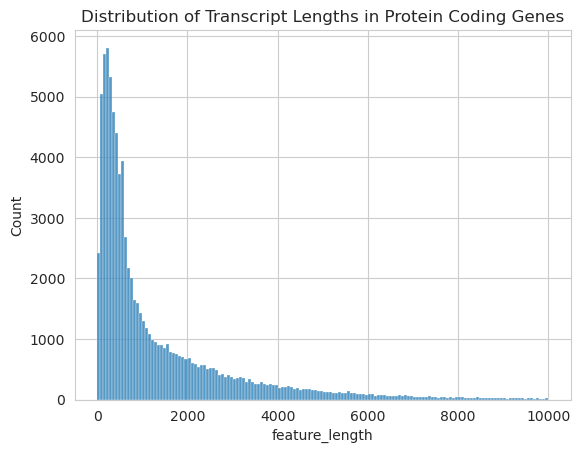

In [15]:
# make a histogram of transcript_length
sns.histplot(data=pc_trans_lengths[pc_trans_lengths.feature_length < 10000], x="feature_length")
plt.title("Distribution of Transcript Lengths in Protein Coding Genes")

# medium 1000-3000
# try 3000 as cutoff for long ... 

Text(0.5, 1.0, 'Distribution of Transcript Lengths in lncRNA Genes')

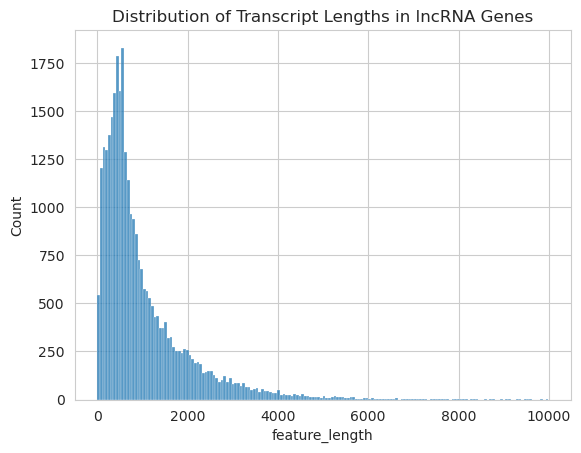

In [16]:
sns.histplot(data=nc_trans_lengths[nc_trans_lengths.feature_length < 10000], x="feature_length")
plt.title("Distribution of Transcript Lengths in lncRNA Genes")

In [17]:
# first need to attach chr, start and end positions to tables 
pc_trans_lengths = pc_trans_lengths.reset_index()
nc_trans_lengths = nc_trans_lengths.reset_index()

In [18]:
pc_trans_lengths = pc_trans_lengths.merge(coords, on="transcript_id")
nc_trans_lengths = nc_trans_lengths.merge(coords, on="transcript_id")

In [19]:
# reorder columns to match BED file format, chr, start, end, strand
pc_trans_lengths = pc_trans_lengths[["Chromosome", "Start", "End", "Strand", "transcript_id", "gene_name", "feature_length"]]
nc_trans_lengths = nc_trans_lengths[["Chromosome", "Start", "End", "Strand", "transcript_id", "gene_name", "feature_length"]]

In [20]:
# generate three files for protein coding genes BED files for short, medium, and long transcripts
# short: < 1000 bp
# medium: 1000-10000 bp
# long: > 10000 bp

short_pc = pc_trans_lengths[pc_trans_lengths.feature_length < 1000]
med_pc = pc_trans_lengths[pc_trans_lengths.feature_length.between(1000, 10000)]
long_pc = pc_trans_lengths[pc_trans_lengths.feature_length > 10000]
print(short_pc.shape)
print(med_pc.shape)
print(long_pc.shape)

(51210, 7)
(32033, 7)
(669, 7)


In [21]:
# generate three files for protein coding genes BED files for short, medium, and long transcripts
# short: < 1000 bp
# medium: 1000-10000 bp
# long: > 10000 bp

short_nc = nc_trans_lengths[nc_trans_lengths.feature_length < 1000]
med_nc = nc_trans_lengths[nc_trans_lengths.feature_length.between(1000, 10000)]
long_nc = nc_trans_lengths[nc_trans_lengths.feature_length > 10000]
print(short_nc.shape)
print(med_nc.shape)
print(long_nc.shape)

(20008, 7)
(10472, 7)
(28, 7)


In [22]:
# choose directory to save these files in
save_dir = "/gpfs/commons/groups/knowles_lab/Karin/genome_files/"

# save files as BED files 
short_pc.to_csv(save_dir + "short_pc.bed", sep="\t", header=False, index=False)
med_pc.to_csv(save_dir + "med_pc.bed", sep="\t", header=False, index=False)
long_pc.to_csv(save_dir + "long_pc.bed", sep="\t", header=False, index=False)
short_nc.to_csv(save_dir + "short_nc.bed", sep="\t", header=False, index=False)
med_nc.to_csv(save_dir + "med_nc.bed", sep="\t", header=False, index=False)
long_nc.to_csv(save_dir + "long_nc.bed", sep="\t", header=False, index=False)

In [23]:
short_pc

,Chromosome,Start,End,Strand,transcript_id,gene_name,feature_length
1,19,58350593,58353129,-,ENST00000600966,A1BG,347
2,10,50806561,50859985,-,ENST00000373993,A1CF,525
3,10,50806561,50885675,-,ENST00000373995,A1CF,143
4,10,50799408,50885627,-,ENST00000373997,A1CF,95
7,10,50836073,50885675,-,ENST00000414883,A1CF,93
...,...,...,...,...,...,...,...
83904,7,143381294,143382925,+,ENST00000449630,ZYX,533
83905,7,143381360,143382676,+,ENST00000457235,ZYX,503
83907,17,4022416,4062798,-,ENST00000573183,ZZEF1,458
83910,1,77633245,77683374,-,ENST00000414381,ZZZ3,273
